# CEM Model - Larger MPNet + 2022 Data (768-dim)

**Runtime:** ~30-40 minutes (longer due to larger embeddings and expanded dataset)

This notebook:
1. Trains **CEM** using larger MPNet-based concept similarity data with 2022 data added (768-dim MAX)
2. Uses **LDAM Loss** for severe class imbalance
3. Tests threshold optimization to maximize minority class detection
4. Evaluates on test set with balanced metrics

**Data Source:** `larger2022_max_alternative_attention_pipeline` (MPNet, 768-dim)
- Model: all-mpnet-base-v2 (768 dimensions)
- Higher quality embeddings than MiniLM (384-dim)
- Uses MAX of concept similarities
- Includes 2022 data (~1,400 subjects added to training pool)

**Prerequisites:** Run `0i_larger2022_max_dataset.ipynb` first!

## Section 0: Setup & Configuration

In [1]:
# Imports
import os
import json
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    balanced_accuracy_score,
    classification_report,
    precision_recall_curve,
)

print("✓ All imports successful")

✓ All imports successful


In [2]:
# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
pl.seed_everything(SEED)

print(f"✓ Random seed set to {SEED}")

Global seed set to 42


✓ Random seed set to 42


In [3]:
# Detect device
if torch.backends.mps.is_available():
    DEVICE = "mps"
    print("✓ Using MacBook GPU (MPS)")
elif torch.cuda.is_available():
    DEVICE = "cuda"
    print("✓ Using CUDA GPU")
else:
    DEVICE = "cpu"
    print("⚠ Using CPU")

✓ Using MacBook GPU (MPS)


In [4]:
# Define paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
DATA_PROCESSED = os.path.join(PROJECT_ROOT, "data/processed")
DATASET_DIR = os.path.join(DATA_PROCESSED, "larger2022_max_alternative_attention_pipeline")
OUTPUT_DIR = "outputs_cem_larger2022"  # Using 2022 expanded dataset

print("✓ Paths configured")
print(f"  Dataset dir: {DATASET_DIR}")
print(f"  Output dir: {OUTPUT_DIR}")

✓ Paths configured
  Dataset dir: /Users/gualtieromarencoturi/Desktop/thesis/Master-Thesis-CEM-Depression-etc-case-study/data/processed/larger2022_max_alternative_attention_pipeline
  Output dir: outputs_cem_larger2022


In [5]:
# Define 21 BDI-II concept names
CONCEPT_NAMES = [
    "Sadness", "Pessimism", "Past failure", "Loss of pleasure",
    "Guilty feelings", "Punishment feelings", "Self-dislike", "Self-criticalness",
    "Suicidal thoughts or wishes", "Crying", "Agitation", "Loss of interest",
    "Indecisiveness", "Worthlessness", "Loss of energy", "Changes in sleeping pattern",
    "Irritability", "Changes in appetite", "Concentration difficulty",
    "Tiredness or fatigue", "Loss of interest in sex"
]
N_CONCEPTS = len(CONCEPT_NAMES)

print(f"✓ Defined {N_CONCEPTS} BDI-II concepts")

✓ Defined 21 BDI-II concepts


In [35]:
# Hyperparameters
HYPERPARAMS = {
    # Model architecture
    "embedding_dim": 768,
    "n_concepts": 21,
    "n_tasks": 1,
    "emb_size": 96,  # Reduced from 192 to prevent overfitting
    
    # CEM-specific
    "shared_prob_gen": True,        # Share probability generator across concepts
    "intervention_prob": 0.25,      # Training intervention probability
    
    # Training
    "batch_size_train": 32,
    "batch_size_eval": 64,
    "max_epochs": 100,
    "learning_rate": 0.01,
    "weight_decay": 4e-4,          # Increased from 4e-5 for stronger regularization
    
    # Loss
    "concept_loss_weight": 1.0,
    
    # LDAM Loss
    "use_ldam_loss": True,          # Enable for class imbalance
    "n_positive": None,             # Will be set after loading data
    "n_negative": None,             # Will be set after loading data
    "ldam_max_margin": 0.5,         # Try: 0.3, 0.5, 0.7, 1.0
    "ldam_scale": 20,               # Try: 20, 30, 40, 50
    
    # Weighted Sampler
    "use_weighted_sampler": False,

    # Threshold selection
    "manual_threshold": 0.025,  # Auto-select threshold from validation set
}

print("✓ Hyperparameters configured")
if HYPERPARAMS['use_ldam_loss']:
    print(f"  Using LDAM LOSS (margin={HYPERPARAMS['ldam_max_margin']}, scale={HYPERPARAMS['ldam_scale']})")
else:
    print(f"  Using standard BCE loss")

✓ Hyperparameters configured
  Using LDAM LOSS (margin=0.5, scale=20)


## Section 1: Load Preprocessed Data

In [7]:
# Load training data
print("Loading preprocessed datasets...")

train_data = np.load(os.path.join(DATASET_DIR, "train_data.npz"))
X_train = train_data['X']
C_train = train_data['C']
y_train = train_data['y']
train_subject_ids = train_data['subject_ids']

print(f"✓ Loaded training data: {X_train.shape}")

Loading preprocessed datasets...
✓ Loaded training data: (388, 768)


In [8]:
# Load validation data
val_data = np.load(os.path.join(DATASET_DIR, "val_data.npz"))
X_val = val_data['X']
C_val = val_data['C']
y_val = val_data['y']
val_subject_ids = val_data['subject_ids']

print(f"✓ Loaded validation data: {X_val.shape}")

✓ Loaded validation data: (98, 768)


In [9]:
# Load test data
test_data = np.load(os.path.join(DATASET_DIR, "test_data.npz"))
X_test = test_data['X']
C_test = test_data['C']
y_test = test_data['y']
test_subject_ids = test_data['subject_ids']

print(f"✓ Loaded test data: {X_test.shape}")

✓ Loaded test data: (401, 768)


In [10]:
# Load class weights
with open(os.path.join(DATASET_DIR, "class_weights.json"), 'r') as f:
    class_info = json.load(f)

n_positive = class_info['n_positive']
n_negative = class_info['n_negative']
pos_weight = class_info['pos_weight']

# Update HYPERPARAMS with actual class counts for LDAM
HYPERPARAMS['n_positive'] = n_positive
HYPERPARAMS['n_negative'] = n_negative

print(f"✓ Loaded class weights:")
print(f"  Negative: {n_negative}, Positive: {n_positive}")
print(f"  Ratio: 1:{pos_weight:.2f}")

✓ Loaded class weights:
  Negative: 322, Positive: 66
  Ratio: 1:4.88


## Section 2: PyTorch Dataset & DataLoaders

In [11]:
class CEMDataset(Dataset):
    def __init__(self, X, C, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.C = torch.tensor(C, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.C[idx]

# Create datasets
train_dataset = CEMDataset(X_train, C_train, y_train)
val_dataset = CEMDataset(X_val, C_val, y_val)
test_dataset = CEMDataset(X_test, C_test, y_test)

# Create WeightedRandomSampler for batch-level oversampling (if enabled)
if HYPERPARAMS['use_weighted_sampler']:
    # Compute class sample counts
    class_sample_counts = np.bincount(y_train.astype(int))  # [n_negative, n_positive]
    weights = 1. / class_sample_counts
    sample_weights = weights[y_train.astype(int)]
    
    # Create sampler
    train_sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # Allow positive samples to appear multiple times
    )
    
    print(f"✓ WeightedRandomSampler created:")
    print(f"  Negative weight: {weights[0]:.4f}")
    print(f"  Positive weight: {weights[1]:.4f}")
    print(f"  Expected positive ratio per batch: ~{weights[1]/(weights[0]+weights[1]):.1%}")
    
    # Create train loader with sampler (shuffle=False when using sampler)
    train_loader = DataLoader(train_dataset, batch_size=HYPERPARAMS['batch_size_train'], sampler=train_sampler)
else:
    # Standard train loader with shuffle
    train_loader = DataLoader(train_dataset, batch_size=HYPERPARAMS['batch_size_train'], shuffle=True)
    print("✓ Using standard DataLoader (shuffle=True)")

# Validation and test loaders (no sampling)
val_loader = DataLoader(val_dataset, batch_size=HYPERPARAMS['batch_size_eval'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=HYPERPARAMS['batch_size_eval'], shuffle=False)

print("✓ All DataLoaders created")

✓ Using standard DataLoader (shuffle=True)
✓ All DataLoaders created


## Section 3: Custom CEM Model Definition

In [12]:
# LDAM Loss (for class imbalance)
class LDAMLoss(nn.Module):
    """
    Label-Distribution-Aware Margin (LDAM) Loss for long-tailed recognition.
    
    Creates class-dependent margins to make decision boundaries harder for minority classes.
    """
    def __init__(self, n_positive, n_negative, max_margin=0.5, scale=30):
        super(LDAMLoss, self).__init__()
        self.max_margin = max_margin
        self.scale = scale
        
        # Compute class frequencies
        total = n_positive + n_negative
        freq_pos = n_positive / total
        freq_neg = n_negative / total
        
        # Compute margins: minority class gets larger margin
        margin_pos = max_margin * (freq_pos ** (-0.25))
        margin_neg = max_margin * (freq_neg ** (-0.25))
        
        self.register_buffer('margin_pos', torch.tensor(margin_pos))
        self.register_buffer('margin_neg', torch.tensor(margin_neg))
    
    def forward(self, logits, targets):
        logits = logits.view(-1)
        targets = targets.view(-1).float()
        
        # Apply class-dependent margins
        margin = targets * self.margin_pos + (1 - targets) * (-self.margin_neg)
        adjusted_logits = (logits - margin) * self.scale
        
        return F.binary_cross_entropy_with_logits(adjusted_logits, targets, reduction='mean')


# Custom CEM Implementation
class CustomCEM(pl.LightningModule):
    """
    Custom Concept Embedding Model (CEM) implementation.
    
    Architecture:
      X → concept_extractor → context_layers → prob_generator → dual_embeddings → task_classifier → y
    """
    def __init__(
        self,
        n_concepts=21,
        emb_size=128,
        input_dim=384,
        shared_prob_gen=True,
        intervention_prob=0.25,
        concept_loss_weight=1.0,
        learning_rate=0.01,
        weight_decay=4e-05,
        use_ldam_loss=True,
        n_positive=83,
        n_negative=403,
        ldam_max_margin=0.5,
        ldam_scale=30,
    ):
        super().__init__()
        self.save_hyperparameters()
        
        self.n_concepts = n_concepts
        self.emb_size = emb_size
        self.intervention_prob = intervention_prob
        self.concept_loss_weight = concept_loss_weight
        
        # Stage 1: Concept Extractor (X → Pre-Concept Features)
        self.concept_extractor = nn.Sequential(
            nn.Linear(input_dim, 256),      # Reduced from 384 to prevent overfitting
            nn.ReLU(),
            nn.Dropout(0.5),                # Increased from 0.4 for stronger regularization
            nn.Linear(256, 256)             # Reduced from 384
        )
        
        # Stage 2: Context Generators (Features → Dual Embeddings)
        # Each concept gets its own context generator
        self.context_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(256, emb_size * 2),  # Input changed from 384 to 256
                nn.LeakyReLU(),
                nn.Dropout(0.5)                # Added dropout for regularization
            ) for _ in range(n_concepts)
        ])
        
        # Stage 3: Probability Generator (Contexts → Concept Probabilities)
        if shared_prob_gen:
            # Single shared generator for all concepts
            self.prob_generator = nn.Linear(emb_size * 2, 1)
        else:
            # Per-concept probability generators
            self.prob_generators = nn.ModuleList([
                nn.Linear(emb_size * 2, 1) for _ in range(n_concepts)
            ])
        
        self.shared_prob_gen = shared_prob_gen
        
        # Stage 4: Task Classifier (Concept Embeddings → Task Output)
        self.task_classifier = nn.Sequential(
            nn.Linear(n_concepts * emb_size, 96),  # Reduced from 192 to prevent overfitting
            nn.LeakyReLU(),
            nn.Dropout(0.5),                       # Increased from 0.3 for stronger regularization
            nn.Linear(96, 1)                       # Input changed from 192
        )
        
        # Loss functions
        self.concept_loss_fn = nn.BCEWithLogitsLoss()
        if use_ldam_loss:
            self.task_loss_fn = LDAMLoss(n_positive, n_negative, ldam_max_margin, ldam_scale)
        else:
            self.task_loss_fn = nn.BCEWithLogitsLoss()
    
    def forward(self, x, c_true=None, train=False):
        # Step 1: Extract pre-concept features
        pre_features = self.concept_extractor(x)  # (B, 256) - reduced from 384
        
        # Step 2: Generate contexts and probabilities per concept
        contexts = []
        c_logits_list = []
        
        for i, context_layer in enumerate(self.context_layers):
            context = context_layer(pre_features)  # (B, emb_size*2)
            
            # Get probability logit
            if self.shared_prob_gen:
                logit = self.prob_generator(context)  # (B, 1)
            else:
                logit = self.prob_generators[i](context)
            
            contexts.append(context)
            c_logits_list.append(logit)
        
        c_logits = torch.cat(c_logits_list, dim=1)  # (B, 21)
        c_probs = torch.sigmoid(c_logits)           # (B, 21)
        
        # Step 3: Apply intervention (optional during training)
        if train and self.intervention_prob > 0 and c_true is not None:
            intervention_mask = torch.bernoulli(
                torch.ones_like(c_probs) * self.intervention_prob
            )
            c_probs = c_probs * (1 - intervention_mask) + c_true * intervention_mask
        
        # Step 4: Mix dual embeddings based on probabilities
        concept_embeddings = []
        for i, context in enumerate(contexts):
            # Split into true/false embeddings
            emb_true = context[:, :self.emb_size]       # First half
            emb_false = context[:, self.emb_size:]      # Second half
            
            # Weight by probability
            prob = c_probs[:, i:i+1]  # (B, 1)
            mixed_emb = emb_true * prob + emb_false * (1 - prob)
            concept_embeddings.append(mixed_emb)
        
        # Concatenate all concept embeddings
        c_embeddings = torch.cat(concept_embeddings, dim=1)  # (B, 21*emb_size)
        
        # Step 5: Task prediction
        y_logits = self.task_classifier(c_embeddings)  # (B, 1)
        
        return c_logits, y_logits
    
    def training_step(self, batch, batch_idx):
        x, y, c_true = batch
        c_logits, y_logits = self.forward(x, c_true=c_true, train=True)
        
        # Task loss (LDAM)
        task_loss = self.task_loss_fn(y_logits.squeeze(), y.squeeze())
        
        # Concept loss (BCE)
        concept_loss = self.concept_loss_fn(c_logits, c_true)
        
        # Combined loss
        loss = task_loss + self.concept_loss_weight * concept_loss
        
        # Logging
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_task_loss', task_loss, on_epoch=True)
        self.log('train_concept_loss', concept_loss, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y, c_true = batch
        c_logits, y_logits = self.forward(x, c_true=c_true, train=False)
        
        # Task loss
        task_loss = self.task_loss_fn(y_logits.squeeze(), y.squeeze())
        
        # Concept loss
        concept_loss = self.concept_loss_fn(c_logits, c_true)
        
        # Combined loss
        loss = task_loss + self.concept_loss_weight * concept_loss
        
        # Logging
        self.log('val_loss', loss, on_epoch=True, prog_bar=True)
        self.log('val_task_loss', task_loss, on_epoch=True)
        self.log('val_concept_loss', concept_loss, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )

print("✓ Custom CEM model defined")

✓ Custom CEM model defined


## Section 4: Model Initialization

In [13]:
# Initialize Custom CEM model
custom_cem = CustomCEM(
    n_concepts=HYPERPARAMS['n_concepts'],
    emb_size=HYPERPARAMS['emb_size'],
    input_dim=HYPERPARAMS['embedding_dim'],
    shared_prob_gen=HYPERPARAMS['shared_prob_gen'],
    intervention_prob=HYPERPARAMS['intervention_prob'],
    concept_loss_weight=HYPERPARAMS['concept_loss_weight'],
    learning_rate=HYPERPARAMS['learning_rate'],
    weight_decay=HYPERPARAMS['weight_decay'],
    use_ldam_loss=HYPERPARAMS['use_ldam_loss'],
    n_positive=HYPERPARAMS['n_positive'],
    n_negative=HYPERPARAMS['n_negative'],
    ldam_max_margin=HYPERPARAMS['ldam_max_margin'],
    ldam_scale=HYPERPARAMS['ldam_scale']
)

print("✓ Custom CEM model initialized")
print(f"  Using LDAM Loss (margin={HYPERPARAMS['ldam_max_margin']}, scale={HYPERPARAMS['ldam_scale']})")
print(f"  Concept embedding size: {HYPERPARAMS['emb_size']}")
print(f"  Intervention probability: {HYPERPARAMS['intervention_prob']}")
print(f"  Shared probability generator: {HYPERPARAMS['shared_prob_gen']}")
print(f"  Class counts: {HYPERPARAMS['n_positive']} positive, {HYPERPARAMS['n_negative']} negative")
print(f"  Data source: Larger MPNet + 2022 data (768-dim MAX)")


✓ Custom CEM model initialized
  Using LDAM Loss (margin=0.5, scale=20)
  Concept embedding size: 96
  Intervention probability: 0.25
  Shared probability generator: True
  Class counts: 66 positive, 322 negative
  Data source: Larger MPNet + 2022 data (768-dim MAX)


# Setup trainer
from pytorch_lightning.callbacks import EarlyStopping

# Add early stopping callback to prevent overfitting
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=15,
    mode="min",
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=os.path.join(OUTPUT_DIR, "models"),
    filename="cem-larger-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=HYPERPARAMS['max_epochs'],
    accelerator=DEVICE,
    devices=1,
    logger=CSVLogger(save_dir=os.path.join(OUTPUT_DIR, "logs"), name="cem_larger"),
    log_every_n_steps=10,
    callbacks=[checkpoint_callback, early_stop_callback],  # Added early stopping
    enable_progress_bar=True
)

print("✓ Trainer configured with early stopping (patience=15)")

In [14]:
# Setup trainer
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=os.path.join(OUTPUT_DIR, "models"),
    filename="cem-max-gold-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,
    mode="min"
)

trainer = pl.Trainer(
    max_epochs=HYPERPARAMS['max_epochs'],
    accelerator=DEVICE,
    devices=1,
    logger=CSVLogger(save_dir=os.path.join(OUTPUT_DIR, "logs"), name="cem_max_gold"),
    log_every_n_steps=10,
    callbacks=[checkpoint_callback],
    enable_progress_bar=True
)

print("✓ Trainer configured")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


✓ Trainer configured


In [15]:
# Train model
print("\nStarting training...\n")
trainer.fit(custom_cem, train_loader, val_loader)
print("\n✓ Training complete!")

/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory outputs_cem_larger2022/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name              | Type              | Params
--------------------------------------------------------
0 | concept_extractor | Sequential        | 262 K 
1 | context_layers    | ModuleList        | 1.0 M 
2 | prob_generator    | Linear            | 193   
3 | task_classifier   | Sequential        | 193 K 
4 | concept_loss_fn   | BCEWithLogitsLoss | 0     
5 | task_loss_fn      | LDAMLoss          | 0     
--------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.971     Total estimated model params size (MB)



Starting training...



Sanity Checking: 0it [00:00, ?it/s]

/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/miniconda3/envs/38concept_embedding/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.



✓ Training complete!


In [36]:
## Validation threshold optimization

print("\nRunning inference on validation set for threshold selection...")

custom_cem.eval()
device_obj = torch.device(DEVICE)
custom_cem = custom_cem.to(device_obj)

y_val_true = []
y_val_prob = []

with torch.no_grad():
    for x_batch, y_batch, _ in val_loader:
        x_batch = x_batch.to(device_obj)

        _, y_logits = custom_cem(x_batch)
        y_probs = torch.sigmoid(y_logits).cpu().squeeze().numpy()

        y_val_true.extend(y_batch.numpy().astype(int).tolist())
        y_val_prob.extend(
            y_probs.tolist() if isinstance(y_probs, np.ndarray) else [y_probs]
        )

y_val_true = np.array(y_val_true)
y_val_prob = np.array(y_val_prob)

print("✓ Validation inference complete")



Running inference on validation set for threshold selection...
✓ Validation inference complete


In [37]:
print("\nSelecting decision threshold on VALIDATION set...")

if HYPERPARAMS['manual_threshold'] is not None:
    # MANUAL threshold override
    best_threshold = HYPERPARAMS['manual_threshold']
    print(f"✓ Using MANUAL threshold: {best_threshold:.3f}")
    print(f"  (Set 'manual_threshold' to None in HYPERPARAMS for automatic selection)")
else:
    # AUTOMATIC threshold selection
    best_threshold = 0.5
    best_metric = -1.0

    THRESHOLDS = np.linspace(0.05, 0.95, 91)

    for threshold in THRESHOLDS:
        y_pred_temp = (y_val_prob >= threshold).astype(int)

        if y_pred_temp.sum() == 0:
            continue

        # choose ONE objective, uncomment the one you want

        # For recall maximization
        metric = recall_score(y_val_true, y_pred_temp)

        # For F1
        #metric = f1_score(y_val_true, y_pred_temp)

        # For MCC
        #metric = matthews_corrcoef(y_val_true, y_pred_temp)

        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold

    print(f"✓ Auto-selected validation threshold: {best_threshold:.3f}")
    print(f"  Optimizing for: recall (change metric in code to optimize differently)")



Selecting decision threshold on VALIDATION set...
✓ Using MANUAL threshold: 0.025
  (Set 'manual_threshold' to None in HYPERPARAMS for automatic selection)


In [38]:
# Concept Prediction Evaluation on Validation Set
print("\n" + "="*70)
print("      VALIDATION SET: CONCEPT PREDICTION EVALUATION")
print("="*70)

# Run inference on validation set to get concept predictions
print("\nRunning inference on validation set for concept evaluation...")

custom_cem.eval()
device_obj = torch.device(DEVICE)
custom_cem = custom_cem.to(device_obj)

val_concept_probs_list = []

with torch.no_grad():
    for x_batch, y_batch, c_batch in val_loader:
        x_batch = x_batch.to(device_obj)

        c_logits, y_logits = custom_cem(x_batch)
        c_probs = torch.sigmoid(c_logits).cpu().numpy()

        val_concept_probs_list.extend(c_probs.tolist())

val_concept_probs = np.array(val_concept_probs_list)  # Shape: (98, 21)

print(f"✓ Validation concept predictions collected: {val_concept_probs.shape}")

# =============================================================================
# SECTION 1: CONCEPT ACTIVATION PROBABILITY STATISTICS
# =============================================================================
print("\n" + "=" * 70)
print("            CONCEPT ACTIVATION PROBABILITY STATISTICS")
print("=" * 70)

for i, concept_name in enumerate(CONCEPT_NAMES):
    probs = val_concept_probs[:, i]

    print(f"\nConcept: {concept_name}")
    print(f"  Mean probability:      {np.mean(probs):.4f}")
    print(f"  Std deviation:         {np.std(probs):.4f}")
    print(f"  Min probability:       {np.min(probs):.4f}")
    print(f"  Max probability:       {np.max(probs):.4f}")
    print(f"  Median probability:    {np.median(probs):.4f}")
    print(f"  25th percentile:       {np.percentile(probs, 25):.4f}")
    print(f"  75th percentile:       {np.percentile(probs, 75):.4f}")

# =============================================================================
# SECTION 2: SAMPLE CONCEPT PROBABILITIES (FIRST 5)
# =============================================================================
print("\n" + "=" * 70)
print("            SAMPLE CONCEPT PROBABILITIES (FIRST 5)")
print("=" * 70)

n_samples_to_show = min(5, val_concept_probs.shape[0])

for i, concept_name in enumerate(CONCEPT_NAMES):
    probs = val_concept_probs[:n_samples_to_show, i]
    probs_str = ", ".join([f"{p:.3f}" for p in probs])
    print(f"{concept_name:<30}: {probs_str}")

# =============================================================================
# SECTION 3: OVERALL STATISTICS
# =============================================================================
print("\n" + "=" * 70)
print("            OVERALL CONCEPT PROBABILITY STATISTICS")
print("=" * 70)

print(f"\nGlobal Statistics (all concepts, all samples):")
print(f"  Shape: {val_concept_probs.shape} (samples × concepts)")
print(f"  Min probability:     {val_concept_probs.min():.4f}")
print(f"  Max probability:     {val_concept_probs.max():.4f}")
print(f"  Mean probability:    {val_concept_probs.mean():.4f}")
print(f"  Median probability:  {np.median(val_concept_probs):.4f}")
print(f"  Std deviation:       {val_concept_probs.std():.4f}")

# Per-sample statistics (average predictions per person)
per_sample_avg = val_concept_probs.mean(axis=1)  # Average across 21 concepts for each person
print(f"\nPer-Sample Average Concept Probability:")
print(f"  Min (across samples):  {per_sample_avg.min():.4f}")
print(f"  Max (across samples):  {per_sample_avg.max():.4f}")
print(f"  Mean:                  {per_sample_avg.mean():.4f}")
print(f"  Median:                {np.median(per_sample_avg):.4f}")

# =============================================================================
# SECTION 4: CONCEPT PREDICTION ACCURACY (vs Ground Truth)
# =============================================================================
print("\n" + "=" * 70)
print("            CONCEPT PREDICTION ACCURACY (Threshold = 0.5)")
print("=" * 70)

# Threshold concept probabilities at 0.5
c_pred_val = (val_concept_probs >= 0.5).astype(int)
c_true_val = C_val  # Ground truth concepts

# Calculate per-concept metrics
concept_metrics_val = []

for i, concept_name in enumerate(CONCEPT_NAMES):
    acc = accuracy_score(c_true_val[:, i], c_pred_val[:, i])

    # Handle cases where precision/recall might be undefined
    if c_pred_val[:, i].sum() == 0:  # No positive predictions
        prec = 0.0
        rec = recall_score(c_true_val[:, i], c_pred_val[:, i], zero_division=0)
        f1 = 0.0
    elif c_true_val[:, i].sum() == 0:  # No positive ground truth
        prec = precision_score(c_true_val[:, i], c_pred_val[:, i], zero_division=0)
        rec = 0.0
        f1 = 0.0
    else:
        prec = precision_score(c_true_val[:, i], c_pred_val[:, i], zero_division=0)
        rec = recall_score(c_true_val[:, i], c_pred_val[:, i], zero_division=0)
        f1 = f1_score(c_true_val[:, i], c_pred_val[:, i], zero_division=0)

    concept_metrics_val.append({
        "concept": concept_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    })

# Calculate average metrics
avg_acc_val = np.mean([m["accuracy"] for m in concept_metrics_val])
avg_prec_val = np.mean([m["precision"] for m in concept_metrics_val])
avg_rec_val = np.mean([m["recall"] for m in concept_metrics_val])
avg_f1_val = np.mean([m["f1"] for m in concept_metrics_val])

# Print summary
print(f"\nAverage Metrics Across All 21 Concepts:")
print(f"  Average Accuracy:  {avg_acc_val:.4f}")
print(f"  Average Precision: {avg_prec_val:.4f}")
print(f"  Average Recall:    {avg_rec_val:.4f}")
print(f"  Average F1:        {avg_f1_val:.4f}")

# Print full table
print(f"\nPer-Concept Performance (sorted by F1 score):")
print(f"{'Concept':<30} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10}")
print("="*70)

sorted_metrics_val = sorted(concept_metrics_val, key=lambda x: x["f1"], reverse=True)

for m in sorted_metrics_val:
    print(f"{m['concept']:<30} {m['accuracy']:<10.4f} {m['precision']:<10.4f} {m['recall']:<10.4f} {m['f1']:<10.4f}")

print("="*70)

print("\n✓ Validation concept evaluation complete")



      VALIDATION SET: CONCEPT PREDICTION EVALUATION

Running inference on validation set for concept evaluation...
✓ Validation concept predictions collected: (98, 21)

            CONCEPT ACTIVATION PROBABILITY STATISTICS

Concept: Sadness
  Mean probability:      0.0495
  Std deviation:         0.0851
  Min probability:       0.0000
  Max probability:       0.2455
  Median probability:    0.0004
  25th percentile:       0.0000
  75th percentile:       0.0577

Concept: Pessimism
  Mean probability:      0.0658
  Std deviation:         0.1404
  Min probability:       0.0000
  Max probability:       0.4220
  Median probability:    0.0001
  25th percentile:       0.0000
  75th percentile:       0.0231

Concept: Past failure
  Mean probability:      0.0791
  Std deviation:         0.1483
  Min probability:       0.0000
  Max probability:       0.4464
  Median probability:    0.0001
  25th percentile:       0.0000
  75th percentile:       0.0619

Concept: Loss of pleasure
  Mean probabili

## Section 6: Test Evaluation

In [39]:
# Run inference on test set
print("Running inference on test set...")

custom_cem.eval()
device_obj = torch.device(DEVICE)
custom_cem = custom_cem.to(device_obj)

y_true_list = []
y_prob_list = []
concept_probs_list = []

with torch.no_grad():
    for x_batch, y_batch, c_batch in test_loader:
        x_batch = x_batch.to(device_obj)
        
        c_logits, y_logits = custom_cem(x_batch)
        c_probs = torch.sigmoid(c_logits).cpu().numpy()
        y_probs = torch.sigmoid(y_logits).cpu().squeeze().numpy()
        
        y_true_list.extend(y_batch.numpy().astype(int).tolist())
        y_prob_list.extend(y_probs.tolist() if isinstance(y_probs, np.ndarray) else [y_probs])
        concept_probs_list.extend(c_probs.tolist())

y_true = np.array(y_true_list)
y_prob = np.array(y_prob_list)

concept_probs = np.array(concept_probs_list)

print("✓ Inference complete")

Running inference on test set...
✓ Inference complete


In [40]:
# Use best threshold for final predictions
y_pred = (y_prob >= best_threshold).astype(int)

## Section 7: Results Display

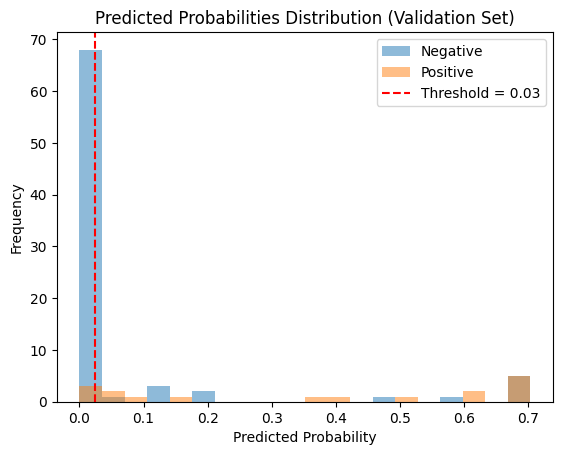

In [41]:
plt.hist(y_val_prob[y_val_true == 0], bins=20, alpha=0.5, label='Negative')
plt.hist(y_val_prob[y_val_true == 1], bins=20, alpha=0.5, label='Positive')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Threshold = {best_threshold:.2f}')
plt.legend()
plt.title("Predicted Probabilities Distribution (Validation Set)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()


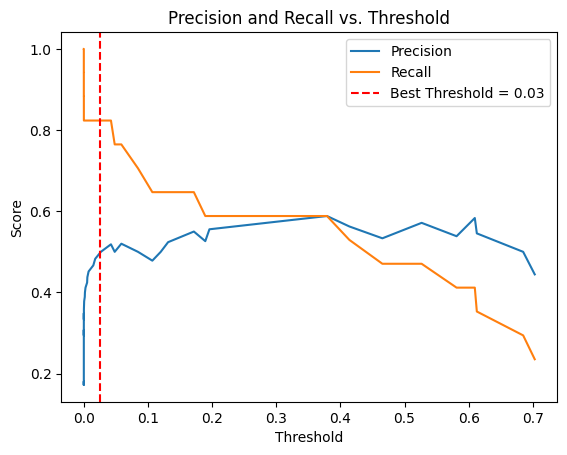

In [42]:
precision, recall, thresholds = precision_recall_curve(y_val_true, y_val_prob)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.legend()
plt.title("Precision and Recall vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.show()

In [43]:
# Compute all metrics
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

acc = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_prob)
mcc = matthews_corrcoef(y_true, y_pred)
f1_binary = f1_score(y_true, y_pred, pos_label=1)
f1_macro = f1_score(y_true, y_pred, average='macro')
precision_binary = precision_score(y_true, y_pred, pos_label=1)
recall_binary = recall_score(y_true, y_pred, pos_label=1)

# Print results
print("\n" + "="*70)
print("                    TEST SET EVALUATION")
print("="*70)
print(f"\nDecision Threshold: {best_threshold:.2f}")

# Enhanced Confusion Matrix Display
print(f"\n{'CONFUSION MATRIX':^50}")
print("="*50)
print(f"{'':>20} │ {'Predicted Negative':^12} │ {'Predicted Positive':^12}")
print("─"*50)
print(f"{'Actual Negative':>20} │ {f'TN = {tn}':^12} │ {f'FP = {fp}':^12}")
print(f"{'Actual Positive':>20} │ {f'FN = {fn}':^12} │ {f'TP = {tp}':^12}")
print("="*50)
print(f"\n  True Positives:  {tp:>3}/{int(np.sum(y_true)):<3} ({100*tp/np.sum(y_true):>5.1f}% of depression cases caught)")
print(f"  False Negatives: {fn:>3}/{int(np.sum(y_true)):<3} ({100*fn/np.sum(y_true):>5.1f}% of depression cases MISSED)")
print(f"  True Negatives:  {tn:>3}/{int(len(y_true)-np.sum(y_true)):<3} ({100*tn/(len(y_true)-np.sum(y_true)):>5.1f}% of healthy correctly identified)")
print(f"  False Positives: {fp:>3}/{int(len(y_true)-np.sum(y_true)):<3} ({100*fp/(len(y_true)-np.sum(y_true)):>5.1f}% false alarms)")

print(f"\nPerformance Metrics:")
print(f"  Accuracy:                  {acc:.4f}")
print(f"  Balanced Accuracy:         {balanced_acc:.4f}")
print(f"  ROC-AUC:                   {roc_auc:.4f}")
print(f"  Matthews Correlation:      {mcc:.4f}")
print(f"\n  F1 Score (Binary):         {f1_binary:.4f}")
print(f"  F1 Score (Macro):          {f1_macro:.4f}")
print(f"  Precision (Binary):        {precision_binary:.4f}")
print(f"  Recall (Binary):           {recall_binary:.4f}")

print("\n" + classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))
print("="*70)


                    TEST SET EVALUATION

Decision Threshold: 0.03

                 CONFUSION MATRIX                 
                     │ Predicted Negative │ Predicted Positive
──────────────────────────────────────────────────
     Actual Negative │   TN = 302   │   FP = 47   
     Actual Positive │   FN = 12    │   TP = 40   

  True Positives:   40/52  ( 76.9% of depression cases caught)
  False Negatives:  12/52  ( 23.1% of depression cases MISSED)
  True Negatives:  302/349 ( 86.5% of healthy correctly identified)
  False Positives:  47/349 ( 13.5% false alarms)

Performance Metrics:
  Accuracy:                  0.8529
  Balanced Accuracy:         0.8173
  ROC-AUC:                   0.8925
  Matthews Correlation:      0.5172

  F1 Score (Binary):         0.5755
  F1 Score (Macro):          0.7433
  Precision (Binary):        0.4598
  Recall (Binary):           0.7692

              precision    recall  f1-score   support

    Negative       0.96      0.87      0.91       349


In [24]:
# Save results
metrics_dict = {
    "model_type": "cem_larger2022",
    "data_source": "larger2022_max_alternative_attention_pipeline",
    "threshold": float(best_threshold),
    "n_samples": int(len(y_true)),
    "n_positive": int(np.sum(y_true)),
    "n_negative": int(len(y_true) - np.sum(y_true)),
    "accuracy": float(acc),
    "balanced_accuracy": float(balanced_acc),
    "roc_auc": float(roc_auc),
    "mcc": float(mcc),
    "f1_binary": float(f1_binary),
    "f1_macro": float(f1_macro),
    "precision_binary": float(precision_binary),
    "recall_binary": float(recall_binary),
    "confusion_matrix": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}
}

os.makedirs(os.path.join(OUTPUT_DIR, "results"), exist_ok=True)
with open(os.path.join(OUTPUT_DIR, "results/test_metrics.json"), 'w') as f:
    json.dump(metrics_dict, f, indent=4)

# Save predictions
predictions_df = pd.DataFrame({
    'subject_id': test_subject_ids,
    'y_true': y_true,
    'y_pred': y_pred,
    'y_prob': y_prob
})

for i, concept_name in enumerate(CONCEPT_NAMES):
    predictions_df[concept_name] = concept_probs[:, i]

predictions_df.to_csv(os.path.join(OUTPUT_DIR, "results/test_predictions.csv"), index=False)

print(f"✓ Results saved to {OUTPUT_DIR}/results/")

✓ Results saved to outputs_cem_larger2022/results/


In [25]:
print("\n" + "="*70)
print("          CEM LARGER2022 TRAINING COMPLETE")
print("="*70)
print(f"\nGenerated files:")
print(f"  Model checkpoint: {OUTPUT_DIR}/models/")
print(f"  Metrics JSON:     {OUTPUT_DIR}/results/test_metrics.json")
print(f"  Predictions CSV:  {OUTPUT_DIR}/results/test_predictions.csv")
print(f"\nData source: larger2022_max_alternative_attention_pipeline")
print(f"  - Uses MAX-based concept similarity (specialist posts)")
print(f"  - Larger MPNet embeddings (768-dim)")
print(f"  - Includes 2022 data (~1,400 subjects added to training)")
print("="*70)


          CEM LARGER2022 TRAINING COMPLETE

Generated files:
  Model checkpoint: outputs_cem_larger2022/models/
  Metrics JSON:     outputs_cem_larger2022/results/test_metrics.json
  Predictions CSV:  outputs_cem_larger2022/results/test_predictions.csv

Data source: larger2022_max_alternative_attention_pipeline
  - Uses MAX-based concept similarity (specialist posts)
  - Larger MPNet embeddings (768-dim)
  - Includes 2022 data (~1,400 subjects added to training)
